<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [4]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [5]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-03-23 19:35:57--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-03-23 19:35:57 (188 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [6]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [7]:
df.shape

(346, 10)

### Convert to date time object


In [8]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [9]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [10]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - ^C
failed

CondaError: KeyboardInterrupt



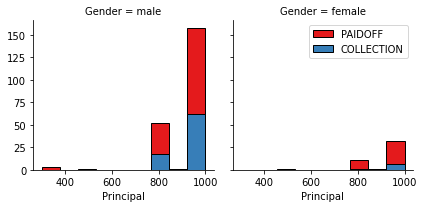

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

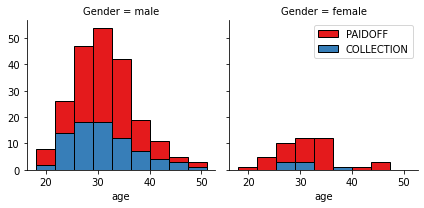

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


NameError: name 'sns' is not defined

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [46]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()


TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [47]:
df[0:5]

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,0,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,0,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,0,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,0,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,0,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [20]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [22]:
# to see the results more easily convert the dependent variable to integers --> 0 for PAIDOFF and 1 for COLLECTION 

df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)

In [23]:
df.head()
print('The dimensions of the original dataset:', df.shape)

The dimensions of the original dataset: (346, 12)


In [24]:
y = df['loan_status'].values
y[0:5]

array([0, 0, 0, 0, 0])

In [25]:
# now for evaluation of the built models and the determination of the optimal K parameter it is a good practice to split the data 
# import the needed library
from sklearn.model_selection import train_test_split

# split so as the testing set becomes 20% of the whole data 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

In [26]:
# check if the splitting has been executed correctly 

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

# 0.2 * 346 ~ 70 so the data was splitted correctly 

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [29]:
# import the needed librares:

# for model builing:
from sklearn.neighbors import KNeighborsClassifier

# for evaluation:
from sklearn import metrics

# as in the previous notebooks we will limit our experiments about the ideal K to the first 9 possible K
# this is because of the limited resources and the fact that inscreasing K means more data points in making averages --> overgeneralize 

# initialize the number of K's we want to test: 
Ks = 10

# make np arrays for storing the values of accuracy and standard deviation of the models with different K values
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model with the training set: 
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    
    #Peredict the possible values of the dependent variable(0/1), and store it in yhat:
    yhat=neigh.predict(X_test)
    
    #Calculate the model's accurecy by comparing the original values(y_test) to the predicted ones(yhat):
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
    #Calculate the standard deviation and store it into an array:
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])


In [30]:
# see the results
print(mean_acc)

[0.67142857 0.77142857 0.71428571 0.77142857 0.75714286 0.78571429
 0.78571429 0.77142857 0.75714286]


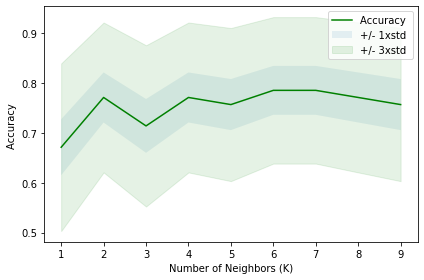

In [31]:
# with this practice we only have to say the model with the highest accuracy score and choose the K it represents 
# we can see the visualization of our results: 
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [32]:
# as the highest values are close together we can choose the maximum element just to be sure
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k= 6


In [33]:
# so the best model in our experinment in view of the accuracy classification score is with k = 6
# let's build this model again to have a usable model object if we need it for later use 

# build the model:
k = 6
bestK_kneigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

# predict the values for the test set 
yhat_Kneigh = bestK_kneigh.predict(X_test)

# evaluate the model based on the resultes (again)
accuracy_bestK = metrics.accuracy_score(y_test, yhat_Kneigh)

print("The model with K = 6 has an accuracy of:", accuracy_bestK )
print("You can use the model anytime with the name of bestK_kneigh")

The model with K = 6 has an accuracy of: 0.7857142857142857
You can use the model anytime with the name of bestK_kneigh


# Decision Tree


In [82]:
# now build a decision tree based on the features we selected 
# it is 8 features that has 2 outcome that we want to predict

#import the needed library:
from sklearn.tree import DecisionTreeClassifier

loanStatTree_6 = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
loanStatTree_15 = DecisionTreeClassifier(criterion="entropy", max_depth = 15)

#print the default  parameters of the tree 
print(loanStatTree_6)
print(loanStatTree_15)

# fit the model onto the training data
loanStatTree_6.fit(X_train,y_train)
loanStatTree_15.fit(X_train,y_train)

#predict based on the tree
yhat_tree_6 = loanStatTree_6.predict(X_test)
yhat_tree_15 = loanStatTree_15.predict(X_test)

print('original test set:')
print(y_test)
print('\n')
print('predicted values:')
print(yhat_tree)

accuracy_tree_6 = metrics.accuracy_score(y_test, yhat_tree_6)
accuracy_tree_15 = metrics.accuracy_score(y_test, yhat_tree_15)
print('Accuracy tree 6:', accuracy_tree_6)
print('Accuracy tree 15:', accuracy_tree_15)
print('Conclusion:')
print(accuracy_tree_15 == accuracy_tree_6)
if(accuracy_tree_15 >= accuracy_tree_6):
    st = 'loanStatTree_15'
    print('The' , st, 'model gives higher or equal accuracy classification score so I go with that one in the final evaluation ')
else:
    st = 'loanStatTree_6'
    print('The' , st, 'model gives higher accuracy classification score so I go with that one in the final evaluation ')
    



DecisionTreeClassifier(criterion='entropy', max_depth=6)
DecisionTreeClassifier(criterion='entropy', max_depth=15)
original test set:
[0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0]


predicted values:
[0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0]
Accuracy tree 6: 0.7714285714285715
Accuracy tree 15: 0.7571428571428571
Conclusion:
False
The loanStatTree_6 model gives higher accuracy classification score so I go with that one in the final evaluation 


# Support Vector Machine


In [67]:
# with support vector machines there are more kernel functions available to reach higher dimensions 
# try out 2 of them to see if we can have an impact on our model

# import the needed library:
from sklearn import svm

# check out for the available kernel functions
svm.SVC?

In [81]:
#  first use the default rbf function

SVM_model_rbf = svm.SVC(kernel='rbf')
SVM_model_rbf.fit(X_train, y_train) 
print(SVM_model_rbf)
# try out the linear function

SVM_model_linear = svm.SVC(kernel='rbf')
SVM_model_linear.fit(X_train, y_train) 
print(SVM_model_linear)

#make a prediction

yhat_SVM_rbf = SVM_model_rbf.predict(X_test)
yhat_SVM_linear = SVM_model_linear.predict(X_test)

print('original:')
print(y_test)
print('predicted rbf:')
print(yhat_SVM_rbf)
print('predicted linear:')
print(yhat_SVM_linear)


accuracy_rbf = metrics.accuracy_score(y_test, yhat_SVM_rbf)
accuracy_linear = metrics.accuracy_score(y_test, yhat_SVM_linear)
print('Accuracy rbf:', accuracy_rbf)
print('Accuracy linear:', accuracy_linear)
print('Conclusion:')
print(accuracy_rbf == accuracy_linear)
if(accuracy_rbf >= accuracy_linear):
    st = 'SVM_model_rbf'
    print('The' , st, 'model gives higher or equal accuracy classification score so I go with that one in the final evaluation ')
else:
    st = 'SVM_model_linear'
    print('The' , st, 'model gives higher accuracy classification score so I go with that one in the final evaluation ')
    

SVC()
SVC()
original:
[0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0]
predicted rbf:
[1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
predicted linear:
[1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Accuracy rbf: 0.7428571428571429
Accuracy linear: 0.7428571428571429
Conclusion:
True
The SVM_model_rbf model gives higher or equal accuracy classification score so I go with that one in the final evaluation 


# Logistic Regression


In [70]:
# import the needed library:
from sklearn.linear_model import LogisticRegression


In [73]:
# use 2 kinds of regularization parameter and 2 optimizer functuin
# first: C = 0.01, function = liblinear
LR_liblinear= LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

# second: C = 1, function = lbfgs
LR_lbfgs = LogisticRegression(C = 1.0, solver = 'lbfgs').fit(X_train, y_train)

In [75]:
yhat_LR_lib = LR_liblinear.predict(X_test)
yhat_LR_lb = LR_lbfgs.predict(X_test)

accuracy_lib = metrics.accuracy_score(y_test, yhat_LR_lib)
accuracy_lb = metrics.accuracy_score(y_test, yhat_LR_lb)
print('Accuracy liblieneat:', accuracy_lib)
print('Accuracy lbfgs:', accuracy_lb)

print('Conclusion:')
print('The second model (LR_lbfgs) gives higher accuracy classification score so I go with that one in the final evaluation ')

Accuracy liblieneat: 0.6857142857142857
Accuracy lbfgs: 0.7285714285714285


# Model Evaluation using Test set


In [83]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [111]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-03-23 21:48:38--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-03-23 21:48:39 (102 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [112]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [113]:
# let's convert the loan_status columns again in the test_df to be consistent:
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)


In [115]:
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,0,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,0,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,0,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,0,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,0,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [116]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,1,1,0,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3
1,5,5,0,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4
2,21,21,0,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5
3,24,24,0,1000,30,2016-09-10,2016-10-09,26,college,male,5
4,35,35,0,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6


In [117]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,0,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,0,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,0,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,0,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,0,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [118]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,0,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,0,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,0,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,0,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,0,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [119]:
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
print(Feature_test.head())

   Principal  terms  age  Gender  weekend
0       1000     30   50       1        0
1        300      7   35       0        1
2       1000     30   43       1        1
3       1000     30   26       0        1
4        800     15   29       0        1


In [120]:
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [121]:
X_test_new = Feature_test
X_test_new[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [122]:
y_test_new = test_df['loan_status'].values
y_test_new[0:5]

array([0, 0, 0, 0, 0])

In [123]:
# normalize the features and convert them into a numpy array
X_test_new = preprocessing.StandardScaler().fit(X_test_new).transform(X_test_new)
X_test_new

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677],
       [-1.24479571, -0.78854628,  0.19650211, -0.50578054,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588, -0.78854628, -1.31937134, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [ 0.49362588,  0.92844966,  0.02807173, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677],
       [-0.66532184, -0.78854628

In [124]:
# we will calculate the accuraties with the models that have gave the highest accuracy classification score in the first round
# with these models let's predict new values for the loan using the new testing set(X_test_new)

# K-neighbours:
yhat_Kneigh = bestK_kneigh.predict(X_test_new)
# Decision Trees:
yhat_tree_6 = loanStatTree_6.predict(X_test_new)
# Support Vector Machine:
yhat_SVM_rbf = SVM_model_rbf.predict(X_test_new)
#Logistic Regression:
yhat_LR_lb = LR_lbfgs.predict(X_test_new)




In [131]:
# calculate the values for the KNN:
jc_KNN = jaccard_score(y_test_new, yhat_Kneigh, pos_label=0)
f1_KNN = f1_score(y_test_new, yhat_Kneigh, average='weighted')
KNN = {'Jaccard':jc_KNN, 'F1-score':f1_KNN}
print(KNN)

# for Decision Tree (depth 6)
jc_tree = jaccard_score(y_test_new, yhat_tree_6, pos_label=0)
f1_tree = f1_score(y_test_new, yhat_tree_6, average='weighted')
Tree = {'Jaccard':jc_tree, 'F1-score':f1_tree}
print(Tree)


# for SVM
jc_SVM = jaccard_score(y_test_new, yhat_SVM_rbf, pos_label=0)
f1_SVM = f1_score(y_test_new, yhat_SVM_rbf, average='weighted')
SVM = {'Jaccard':jc_SVM, 'F1-score':f1_SVM}
print(SVM)

# for Logistic Regression

jc_LR = jaccard_score(y_test_new, yhat_LR_lb, pos_label=0)
f1_LR = f1_score(y_test_new, yhat_LR_lb, average='weighted')




{'Jaccard': 0.6792452830188679, 'F1-score': 0.626541384672668}
{'Jaccard': 0.7115384615384616, 'F1-score': 0.6704776923582364}
{'Jaccard': 0.78, 'F1-score': 0.7583503077293734}


In [129]:
# for calculating the log loss we need the actual preducted number between 0-1 (not binary outcome, more likely the probability)
yhat_prob = LR_lbfgs.predict_proba(X_test_new)
yhat_prob

array([[0.99337921, 0.00662079],
       [0.72850909, 0.27149091],
       [0.75264222, 0.24735778],
       [0.51035593, 0.48964407],
       [0.58647442, 0.41352558],
       [0.57714913, 0.42285087],
       [0.57844522, 0.42155478],
       [0.54771728, 0.45228272],
       [0.73021112, 0.26978888],
       [0.70296656, 0.29703344],
       [0.49281641, 0.50718359],
       [0.66956223, 0.33043777],
       [0.53731133, 0.46268867],
       [0.75606684, 0.24393316],
       [0.7029078 , 0.2970922 ],
       [0.58295822, 0.41704178],
       [0.71837365, 0.28162635],
       [0.79741846, 0.20258154],
       [0.53250378, 0.46749622],
       [0.61001034, 0.38998966],
       [0.55209615, 0.44790385],
       [0.58988711, 0.41011289],
       [0.98908961, 0.01091039],
       [0.98133342, 0.01866658],
       [0.9766799 , 0.0233201 ],
       [0.97029687, 0.02970313],
       [0.98166994, 0.01833006],
       [0.9868246 , 0.0131754 ],
       [0.97514486, 0.02485514],
       [0.97348976, 0.02651024],
       [0.

In [133]:
# from that we can calculate the log loss: 
logLoss = log_loss(y_test_new, yhat_prob)
LR = {'Jaccard':jc_LR, 'F1-score':f1_LR, 'LogLoss':logLoss}
print(LR)

{'Jaccard': 0.7358490566037735, 'F1-score': 0.6604267310789049, 'LogLoss': 0.4709147371481837}


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


In [140]:
# create the report dataframe:
report = pd.DataFrame(columns=['Jaccard','F1-score','LogLoss'], index=['KNN','Decision Tree','SVM', 'LogisticRegression'])
report.head()

# fill in the data with the dictionaries that we specified:
report.loc['KNN'] = pd.Series(KNN)
report.loc['Decision Tree'] = pd.Series(Tree)
report.loc['SVM'] = pd.Series(SVM)
report.loc['LogisticRegression'] = pd.Series(LR)
report.head()


,Jaccard,F1-score,LogLoss
KNN,0.679245,0.626541,NaN
Decision Tree,0.711538,0.670478,NaN
SVM,0.78,0.75835,NaN
LogisticRegression,0.735849,0.660427,0.470915


# Conclusions:

The Jaccard-indexes are quite impressing and the F1-score is not far ahead of them. The __best results__ came from the __Support Vector Machine algorithm  with rbf kernel function__. The log loss is quite low in case of Logistic Regression so more exploration is needed while building this kind of model. 